In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sn
sn.color_palette("hls", 17)
import scipy.stats as st
import math

import pingouin as pg

In [2]:
import sys
import os
sys.path.append(os.path.join(".."))

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','safecom-2011-present-NASA.xlsx')
df = pd.read_excel(csv_file_name,sheet_name='safecom-2011-present-NASA')
df['fiscal_year'].value_counts()

C:\Users\srandrad\Anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,


2021    2543
2020    1392
2016     998
2018     943
2017     894
2015     714
2019     611
2014       3
2009       1
Name: fiscal_year, dtype: int64

In [4]:
#NIFC based in boise
#idaho and wyoming are split in regions
def correct_regions(df):
    region_dict ={
        'Region 05 Pacific Southwest Region': ['5', 'California', 'Hawaii', 'Pacific West Regional Office','California State Office','R2-Southwest Regional Office'],
        'Region 06 Pacific Northwest Region':['Oregon/Washington State Office', 'Washington', 'Oregon', 'Washington Office','R9-Washington Office',
                                             'PNW Research Station FIA','R1-Pacific Regional Office'],
        'Region 01 Northern Rockies Region':['Montana/Dakotas State Office', 'Montana'], 
        'Region 04 Intermountain Region':['Nevada State Office','DOI-OAS - Headquarters Boise', 'Intermountain Regional NPS Headquarters',
                                         'Utah','Utah State Office', 'Nevada', 'National Interagency Fire Center', 'DOI-OAS - Western Region Office',
                                         'DOI-OAS - Technical Services', 'DOI-OAS - Unmanned Aircraft System Office'],
        'Region 03 Southwest Region':['Southeast Region','Arizona State Office','Arizona','New Mexico','New Mexico State Office'],
        'Region 09 Eastern Area Region':['New Jersey', 'Pennsylvania', 'Minnesota','Pennsylvania','Midwest Regional NPS Headquarters','R3-Great Lakes - Big Rivers Regional Office',
                                        'Northeast Regional Office', 'DOI-OAS - Eastern Region Office','Northeastern Area, S&PF','Wisconsin','Eastern States Office','National Capitol Parks'],
        'Region 02 Rocky Mountain Region':['Colorado State Office', 'Colorado','R6-Mountain-Praire Regional Office', 'DMBM - Migratory Birds', 'Wyoming'], 
        'Region 08 Southern Area Region':['Gulf of Mexico Region','Texas','Oklahoma','North Carolina', 'South Carolina','Florida','R4-Southeast Regional Office'],
        'Region 10 Alaska Region': ['Alaska State Office','Alaska OCS Region', 'Alaska Regional Office', 'Alaska','DOI-OAS - Alaska Regional Office',
                                   'R7-Alaska Regional Office']

    }
    regions_corrected = []
    indices_to_drop = []
    for i in range(len(df)):
        current_region = df.iloc[i]['region']
        correct_region = None
        for region in region_dict:
            if (region == current_region) or (current_region in region_dict[region]):
                correct_region = region
                break 
        if not correct_region:
            correct_region = current_region
        if correct_region in ['CAMP â€“ Campaign Against Marijuana Program', 'Commercial Aircraft Services', 'Aircraft Operations Center','National Capitol Parks', 'Department of Defense', 'National Guard']:
            indices_to_drop.append(i)
        if correct_region == 'Idaho':
            if df.iloc[i]['event_location'] in ['Clear Creak Fire', 'garden valley', 'Idaho City', 'Idaho City Helibase (U98)','Ranft Fire']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 01 Northern Rockies Region'
        elif correct_region == 'Pacific Region':
            correct_region = 'Region 05 Pacific Southwest Region'
        elif correct_region == 'Idaho State Office':
            if df.iloc[i]['event_location'] in ['Granite Creek Fire', '47.512775, -116.002886','Post Falls, ID']:
                correct_region = 'Region 01 Northern Rockies Region'
            else: 
                correct_region = 'Region 04 Intermountain Region'
        elif correct_region == 'Wyoming State Office':
            if df.iloc[i]['event_location'] in ['Tokewanna Fire','Rock Springs Sweetwater County', 'Evanston, WY Airport']:
                correct_region = 'Region 04 Intermountain Region'
            else:
                correct_region = 'Region 02 Rocky Mountain Region'
        regions_corrected.append(correct_region)

    df['region_corrected'] = regions_corrected
    df = df.drop(indices_to_drop, axis=0).reset_index(drop=True)
    return df

In [5]:
list_of_attributes = ['narr_public']#, 'corrective_public', 'notes']
extra_cols = ['region', 'agency', 'duplicate_yn', 'completed_yn', 'rep_by_org',
                   'air_number', 'air_type', 'air_model', 'air_manufacturer',
                   'air_owner', 'mission_destination', 'mission_depart', 'mission_hazmat',
                   'mission_special_use', 'mission_pax', 'mission_procurement_other',
                   'mission_procurement', 'mission_type_other', 'mission_type',
                   'event_damage', 'event_injuries', 'event_org', 'event_org_other',
                   'event_state', 'event_location', 'event_time', 'event_date',
                   'public_yn', 'sequence_number', 'fiscal_year', 'unitid', 'safecomid',
                   'id']
document_id_col = 'id'
csv_file_name = os.path.join(os.path.dirname(os.getcwd()),'data','safecom-2011-present-NASA.xlsx')

file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','preprocessed_data.csv')
safecom = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
safecom.extract_preprocessed_data(file)
preprocessed_df = safecom.data_df

In [6]:
preprocessed_df = preprocessed_df.loc[(preprocessed_df['fiscal_year']>2014) & (preprocessed_df['fiscal_year']<2021)].reset_index(drop=True)

In [7]:
hazard_file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','hazard_interpretation_SAFECOM_V0.xlsx')
results_file = os.path.join(os.path.dirname(os.getcwd()),'results','test_safecom_topics-Sep-21-2021','lda_results.xlsx')

In [8]:
hazard_info = pd.read_excel(hazard_file, sheet_name=['topic-focused'])
hazard_info

{'topic-focused':    Topic Number  Unnamed: 1  Topic Level  Unnamed: 3  \
 0            33         NaN            1         NaN   
 1            87         NaN            1         NaN   
 2             7         NaN            1         NaN   
 
                                Relevant hazard words  Unnamed: 5  Unnamed: 6  \
 0  hydraulic, fluid, hydraulic fluid, leak, hydra...         NaN         NaN   
 1  drone, law, enforcement, law enforcement, oper...         NaN         NaN   
 2  bucket, water, dip, dip site, drop, site, wate...         NaN         NaN   
 
    Relevant Category words  Unnamed: 8  Unnamed: 9  Best Document  \
 0                      NaN         NaN         NaN            NaN   
 1                      NaN         NaN         NaN            NaN   
 2                      NaN         NaN         NaN            NaN   
 
    Unnamed: 11  Quality  Negation words  Unnamed: 14  Hazard Category  \
 0          NaN      NaN             NaN          NaN              NaN 

In [9]:
frequency, docs = identify_docs_per_hazard(hazard_file, preprocessed_df, results_file, "narr_public", 'fiscal_year', "id")

In [10]:
def safecom_severity(passengers, injury, damage):
    key_dict = {"f":0, "t":1}
    severity = float(passengers)*(key_dict[injury] + key_dict[damage])
    if np.isnan(severity):
        severity=0
    return severity

In [11]:
def create_table(docs, frequency, preprocessed_df, id_field, categories, subcategories, hazards, time_field):
    table = pd.DataFrame({"Category": categories, "Subcategory": subcategories, "Hazards": hazards})
    time_period = preprocessed_df[time_field].unique()
    severities = {name:{str(time_p):[] for time_p in time_period} for name in hazards}
    rates = {name:{str(time_p):0 for time_p in time_period} for name in hazards}
    total_docs_per_year = preprocessed_df[time_field].value_counts()
    total_rates = {hazard:0 for hazard in hazards}
    total_hazard_freq = {hazard:0 for hazard in hazards}
    total_severities_hazard = {hazard:0 for hazard in hazards}
    total_docs = len(preprocessed_df)
    for hazard in hazards:
        for year in docs[hazard]:
            for doc in docs[hazard][year]:
                doc_df = preprocessed_df.loc[preprocessed_df[id_field] == doc].reset_index(drop=True)
                severities[hazard][year].append(safecom_severity(doc_df.iloc[0]['mission_pax'], doc_df.iloc[0]['event_injuries'], doc_df.iloc[0]['event_damage']))
            rates[hazard][year] = frequency[hazard][year]/total_docs_per_year[int(year)]
            total_hazard_freq[hazard] += frequency[hazard][year]
        total_rates[hazard] = total_hazard_freq[hazard]/total_docs
        total_severities_hazard[hazard] = np.average([sev for year in severities[hazard] for sev in severities[hazard][year]])
    table["Frequency"] = [total_hazard_freq[hazard] for hazard in total_hazard_freq]
    table["Rate"] = [total_rates[hazard] for hazard in total_rates]
    table["Severity"] = [total_severities_hazard[hazard] for hazard in total_severities_hazard]
    return table, severities, rates
    

In [12]:
categories = ['Airspace','Incident','Maintenance',]
subcategories = ["UAS", 'Mission Equipment','Landing Gear']
hazards = ['Drone Incursion','Water Drop','Hydraulic Fluid Issues']
table, severities, rates = create_table(docs, frequency, preprocessed_df, "id", categories, subcategories, hazards, 'fiscal_year')

In [13]:
table

,Category,Subcategory,Hazards,Frequency,Rate,Severity
0,Airspace,UAS,Drone Incursion,174,0.036379,0.051724
1,Incident,Mission Equipment,Water Drop,726,0.151788,0.298898
2,Maintenance,Landing Gear,Hydraulic Fluid Issues,154,0.032197,0.090909


In [14]:
def plot_metric_time_series(metric_data, metric_name, line_styles=[], markers=[], title="", time_name="Year"):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    averages = {hazard: [np.average(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    stddevs = {hazard: [np.std(metric_data[hazard][year]) for year in time_vals] for hazard in metric_data}
    colors = cm.tab20(np.linspace(0, 1, len(averages)))
    plt.figure()
    plt.title(title, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.ylabel(metric_name, fontsize=16)
    i=0
    for hazard in averages:
        plt.errorbar(time_vals, averages[hazard], yerr=stddevs[hazard], color=colors[i], marker=markers[i], linestyle=line_styles[i], label=hazard, capsize=5, markeredgewidth=1)
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.tick_params(labelsize=16)
    plt.show()
    

In [15]:
def plot_frequency_time_series(metric_data, metric_name='Frequency', line_styles=[], markers=[], title="", time_name="Year"):
    time_vals = list(set([year for hazard in metric_data for year in metric_data[hazard]]))
    time_vals.sort()
    frequencies = {hazard: [frequency[hazard][year] for year in time_vals] for hazard in frequency}
    hazard_freqs_scaled = {hazard: minmax_scale(frequencies[hazard]) for hazard in frequencies}
    colors = cm.tab20(np.linspace(0, 1, len(frequencies)))
    plt.figure()
    plt.ylabel("Total Scaled "+metric_name, fontsize=16)
    plt.xlabel(time_name, fontsize=16)
    plt.title(title, fontsize=16)
    i = 0
    for hazard in hazard_freqs_scaled:
        plt.plot(time_vals, hazard_freqs_scaled[hazard], color=colors[i], label=hazard, marker=markers[i], linestyle=line_styles[i])
        i += 1
    plt.legend(bbox_to_anchor=(1, 1.1), loc='upper left', fontsize=14)
    plt.tick_params(labelsize=16)
    plt.show()

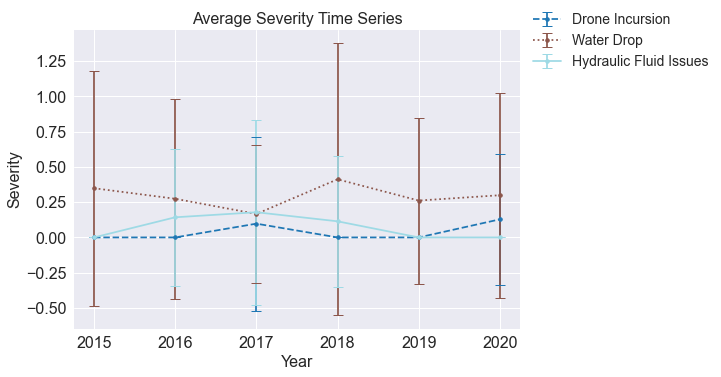

In [16]:
markers = ['.','.','.']
line_styles = ['--', ':','-']

plot_metric_time_series(metric_data=severities, metric_name="Severity", line_styles=line_styles, markers=markers, title="Average Severity Time Series", time_name='Year')

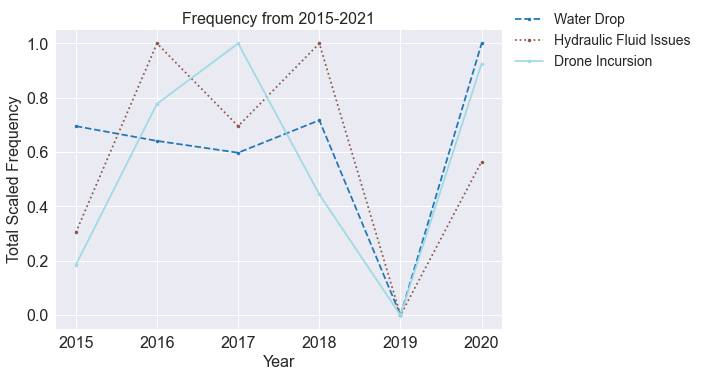

In [17]:
plot_frequency_time_series(frequency, metric_name='Frequency', line_styles=line_styles, markers=markers, title="Frequency from 2015-2021", time_name="Year")

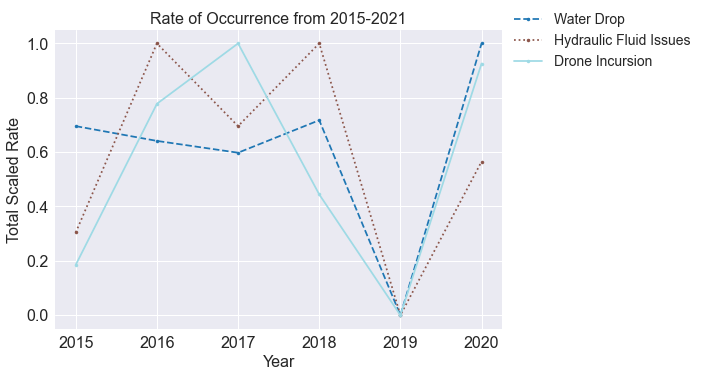

In [18]:
plot_frequency_time_series(rates, metric_name='Rate', line_styles=line_styles, markers=markers, title="Rate of Occurrence from 2015-2021", time_name="Year")

# Pie Charts

In [19]:
def make_pie_chart(docs, data, predictor, hazards, id_field, predictor_label=None):
    if not predictor_label: predictor_label=predictor
    fig, axes = plt.subplots(1,len(hazards), figsize=(10,5))
    for ax, hazard in zip(axes, hazards):
        total_docs = [doc for year in docs[hazard] for doc in docs[hazard][year]]
        hazard_data = data.loc[data[id_field].isin(total_docs)].reset_index(drop=True)
        label = hazard_data[predictor].value_counts().index.sort_values()
        values = [hazard_data[predictor].value_counts()[val] for val in label]
        colors = cm.coolwarm(np.linspace(0, 1, len(label)))
        ax.pie(values, labels=label, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 12},labeldistance=None, pctdistance=1.2)
        ax.set_title(hazard+" per "+predictor_label, fontdict={'fontsize': 14})
    axes[0].legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
    plt.show()

In [20]:
correct_regions(preprocessed_df)

,id,safecomid,unitid,fiscal_year,sequence_number,public_yn,event_date,event_time,event_location,event_state,...,air_model,air_type,air_number,rep_by_org,narr_public,completed_yn,duplicate_yn,agency,region,region_corrected
0,24983,24983,100814,2020,1025,t,2020-08-25,1030,Flathead National Forest,10520.0,...,NaN,10.0,NaN,Forest Service (USFS),"[fix wing, receive, fly, schedule, place, brea...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region
1,24984,24984,100811,2020,1026,t,2020-08-27,09:00:00,DLN,10520.0,...,407,13.0,N144MA,Forest Service (USFS),"[come, fadec, fault, startup, basin, degrade, ...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region
2,24991,24991,100811,2020,1033,t,2020-08-21,NaN,Bear Creek Helibase,10520.0,...,AS350B3,13.0,401HQ,Forest Service (USFS),"[puncture, quickly, psd, successfully, hang, j...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region
3,24978,24978,101926,2020,1020,t,2020-08-23,1800,Frog Fire,10531.0,...,C90,10.0,249CP,Forest Service (USFS),"[previous day, receive, hearing, way, differen...",t,f,Forest Service (USFS),Region 06 Pacific Northwest Region,Region 06 Pacific Northwest Region
4,24889,24889,101920,2020,933,t,2020-08-18,NaN,NaN,10531.0,...,407,13.0,NaN,Forest Service (USFS),"[helispot, cool, fault, ignition, test, allow,...",t,f,Forest Service (USFS),Region 06 Pacific Northwest Region,Region 06 Pacific Northwest Region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,26154,23715,100084,2019,542,t,2019-08-19,NaN,NaN,10494.0,...,146,12.0,N470NA,NaN,"[equipment, protection, structure protection, ...",t,f,Forest Service (USFS),Region 10 Alaska Region,Region 10 Alaska Region
4779,26155,23759,100089,2019,586,t,2019-09-11,755,"Kake Airport, Kake AK",10494.0,...,185,10.0,N9863Q,NaN,"[ditch, take, remove, board, deer, plane, die,...",t,f,Forest Service (USFS),Region 10 Alaska Region,Region 10 Alaska Region
4780,26369,25309,100193,2020,1311,t,2020-09-29,1645,Big Sur,10498.0,...,690,10.0,N690RA,Forest Service (USFS),"[low rpm set, facilitate, reverse, low, pull, ...",t,f,Forest Service (USFS),Region 05 Pacific Southwest Region,Region 05 Pacific Southwest Region
4781,26370,25287,100605,2020,1310,t,2020-09-30,2100,ILS 03 Final OGD over Great Salt Lake,10540.0,...,BE20,10.0,N6300F,Vendor,"[saw, never saw, heard thump, inspection, airp...",t,f,Forest Service (USFS),Region 04 Intermountain Region,Region 04 Intermountain Region


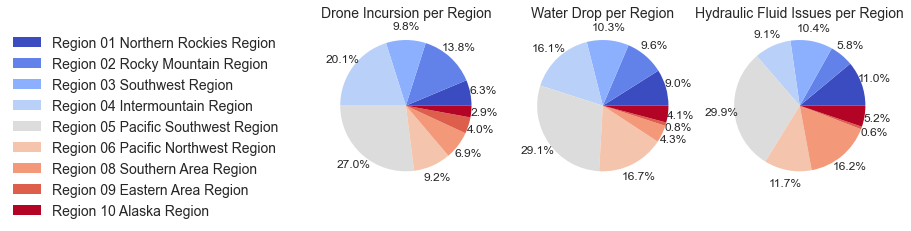

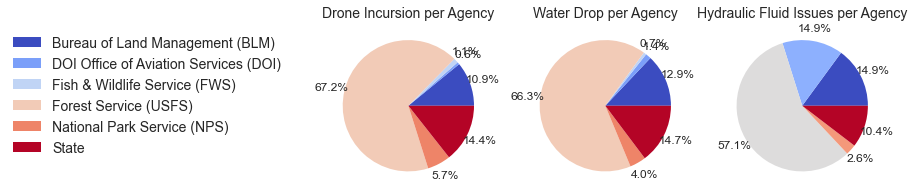

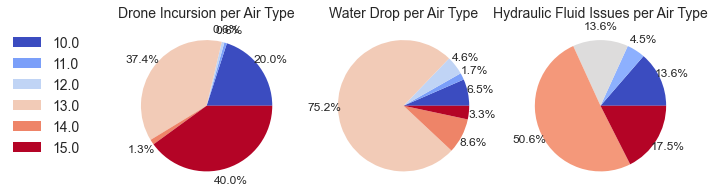

C:\Users\srandrad\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\srandrad\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


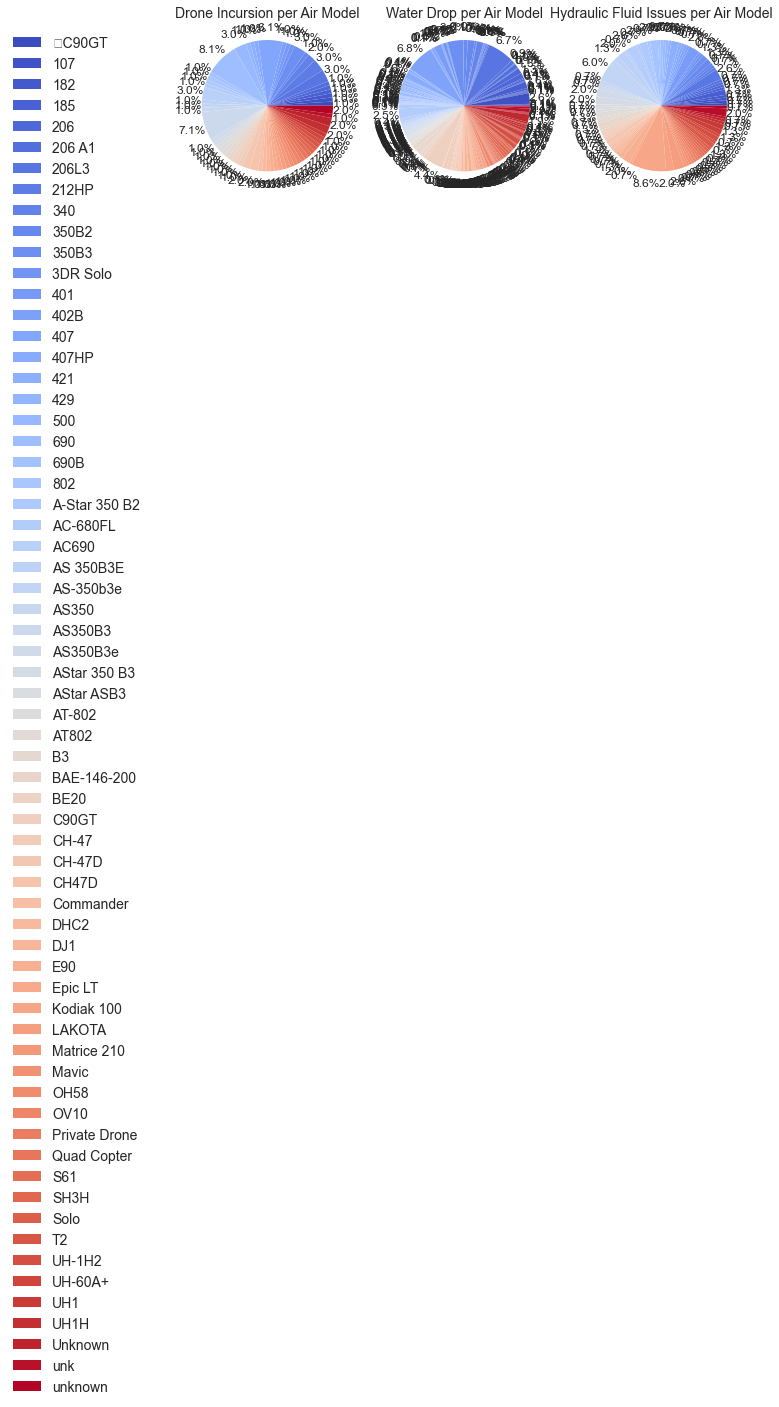

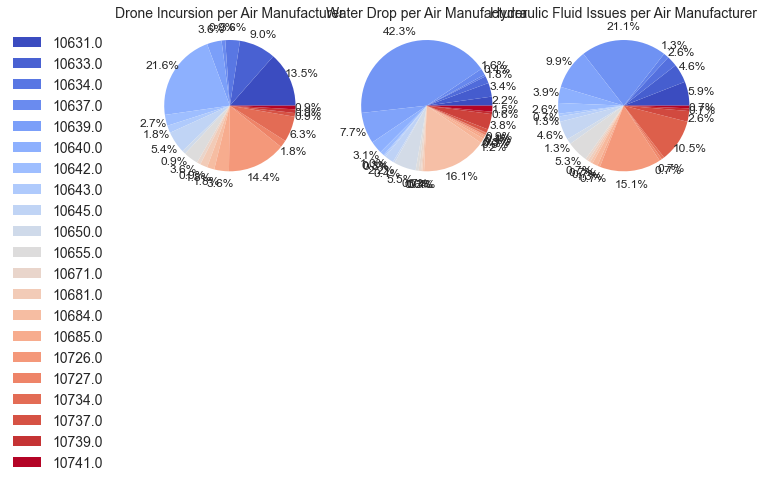

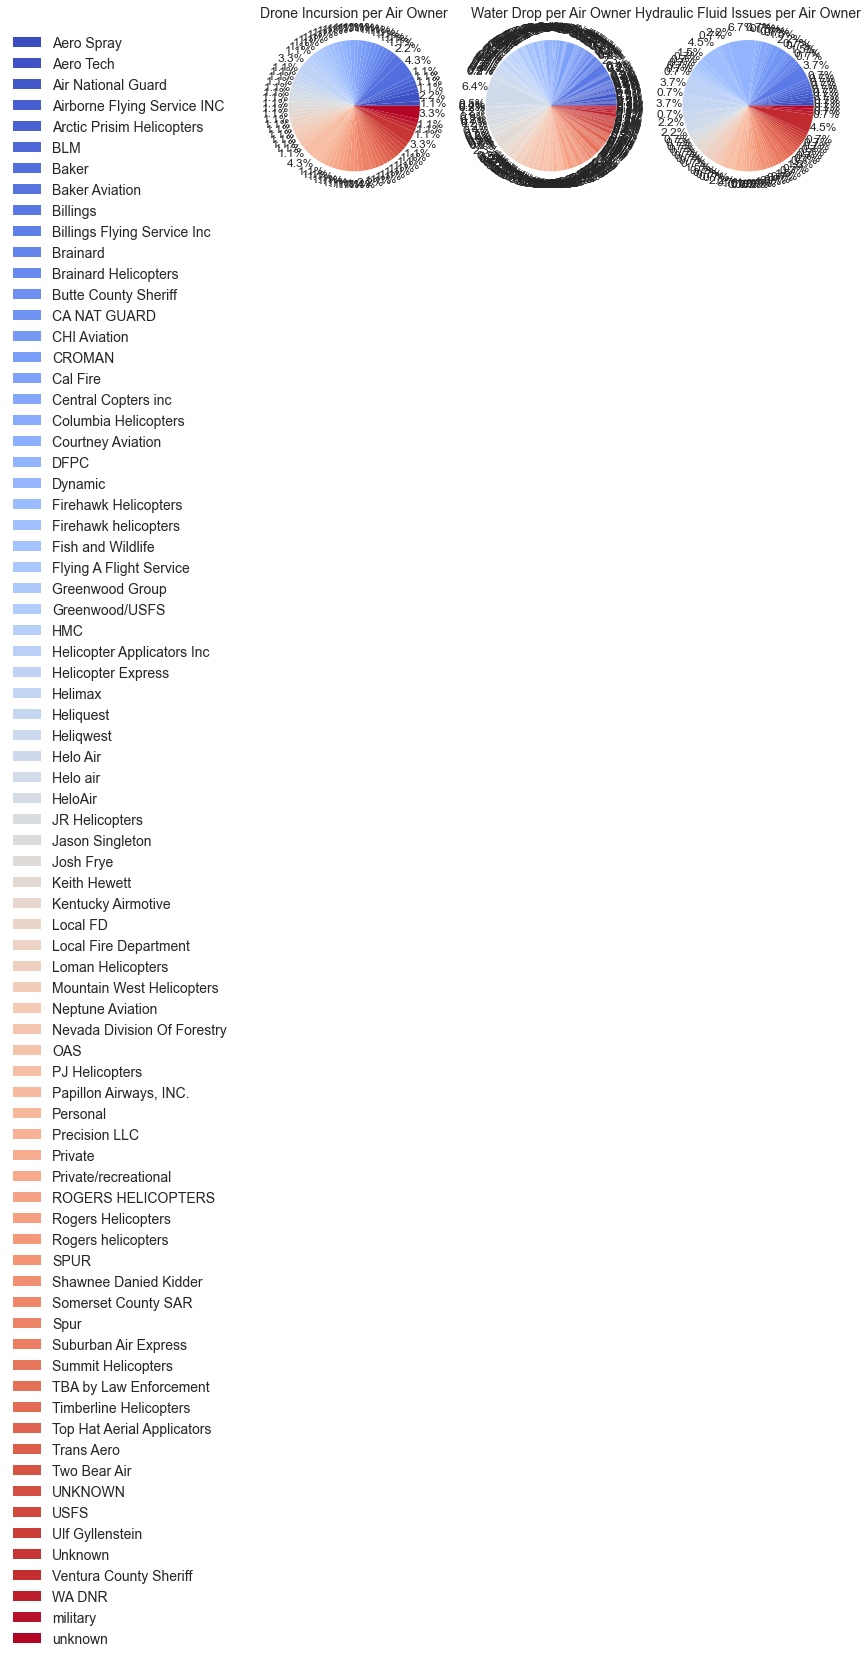

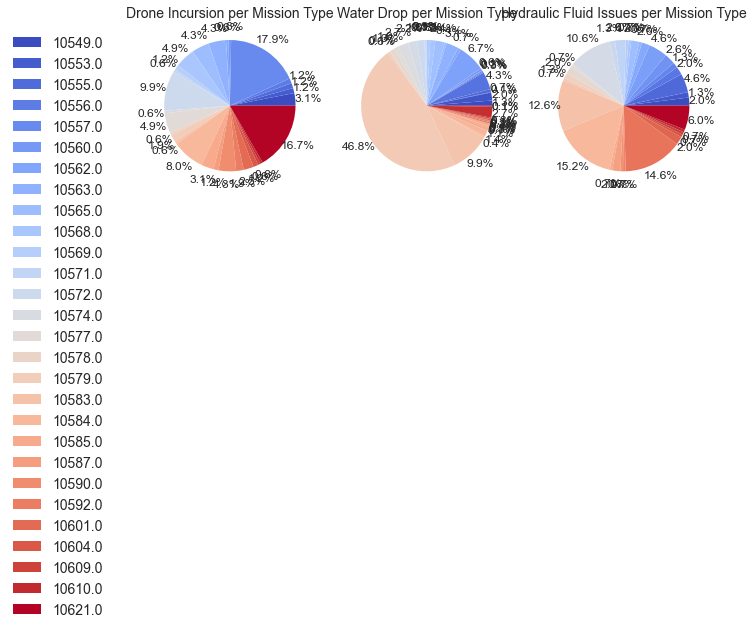

In [21]:
predictors = ['region_corrected', 'agency', 'air_type', 'air_model', 'air_manufacturer',
                   'air_owner', 'mission_type']
for predictor in predictors:
    if predictor == 'region_corrected': predictor_label = 'Region'
    else: 
        predictor_label = " ".join([word.capitalize() for word in predictor.replace("_", " ").split(" ")])
    make_pie_chart(docs, preprocessed_df, predictor, hazards, 'id', predictor_label)

# Chi-Squared Analysis

In [22]:
#add hazard values to preprocessed_df
hazards_per_doc = {doc:[] for doc in preprocessed_df['id']}
hazards_for_df = {hazard:[0 for i in range(len(preprocessed_df))] for hazard in docs}
for hazard in docs:
    for year in docs[hazard]:
        for doc in docs[hazard][year]:
            hazards_for_df[hazard][preprocessed_df.index[preprocessed_df['id']==doc].tolist()[0]] = 1
    preprocessed_df[hazard] = hazards_for_df[hazard]
#add severities
severities = []
for i in range(len(preprocessed_df)):
    severities.append(safecom_severity(preprocessed_df.iloc[i]['mission_pax'], preprocessed_df.iloc[i]['event_injuries'], preprocessed_df.iloc[i]['event_damage']))
preprocessed_df["severity"] = severities
preprocessed_df

,id,safecomid,unitid,fiscal_year,sequence_number,public_yn,event_date,event_time,event_location,event_state,...,narr_public,completed_yn,duplicate_yn,agency,region,region_corrected,Water Drop,Hydraulic Fluid Issues,Drone Incursion,severity
0,24983,24983,100814,2020,1025,t,2020-08-25,1030,Flathead National Forest,10520.0,...,"[fix wing, receive, fly, schedule, place, brea...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region,0,0,0,0.0
1,24984,24984,100811,2020,1026,t,2020-08-27,09:00:00,DLN,10520.0,...,"[come, fadec, fault, startup, basin, degrade, ...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region,0,0,0,0.0
2,24991,24991,100811,2020,1033,t,2020-08-21,NaN,Bear Creek Helibase,10520.0,...,"[puncture, quickly, psd, successfully, hang, j...",t,f,Forest Service (USFS),Region 01 Northern Rockies Region,Region 01 Northern Rockies Region,0,0,0,0.0
3,24978,24978,101926,2020,1020,t,2020-08-23,1800,Frog Fire,10531.0,...,"[previous day, receive, hearing, way, differen...",t,f,Forest Service (USFS),Region 06 Pacific Northwest Region,Region 06 Pacific Northwest Region,0,0,0,0.0
4,24889,24889,101920,2020,933,t,2020-08-18,NaN,NaN,10531.0,...,"[helispot, cool, fault, ignition, test, allow,...",t,f,Forest Service (USFS),Region 06 Pacific Northwest Region,Region 06 Pacific Northwest Region,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,26154,23715,100084,2019,542,t,2019-08-19,NaN,NaN,10494.0,...,"[equipment, protection, structure protection, ...",t,f,Forest Service (USFS),Region 10 Alaska Region,Region 10 Alaska Region,1,0,0,0.0
4779,26155,23759,100089,2019,586,t,2019-09-11,755,"Kake Airport, Kake AK",10494.0,...,"[ditch, take, remove, board, deer, plane, die,...",t,f,Forest Service (USFS),Region 10 Alaska Region,Region 10 Alaska Region,0,0,0,0.0
4780,26369,25309,100193,2020,1311,t,2020-09-29,1645,Big Sur,10498.0,...,"[low rpm set, facilitate, reverse, low, pull, ...",t,f,Forest Service (USFS),Region 05 Pacific Southwest Region,Region 05 Pacific Southwest Region,0,0,0,0.0
4781,26370,25287,100605,2020,1310,t,2020-09-30,2100,ILS 03 Final OGD over Great Salt Lake,10540.0,...,"[saw, never saw, heard thump, inspection, airp...",t,f,Forest Service (USFS),Region 04 Intermountain Region,Region 04 Intermountain Region,0,0,0,0.0


In [23]:
count_dfs = {}
stat_vals = {pred: [] for pred in predictors}
for predictor in predictors:
    vals = []
    hazard_vals = []
    pred_vals = [val for val in preprocessed_df[predictor].value_counts().index]
    diff_observed_expected = {pred_val:[] for pred_val in pred_vals}
    for hazard in hazards:
        expected, observed, stats = pg.chi2_independence(preprocessed_df, x=predictor,y=hazard)
        stat_vals[predictor].append((stats.iloc[0]['pval'].round(3)))
        stat_vals[predictor].append((stats.iloc[0]['chi2'].round(3)))
        for i in range(len(expected)):
            pred_val = expected.index[i]
            diff_observed_expected[pred_val].append(observed.iloc[i][0] - expected.iloc[i][0])
            diff_observed_expected[pred_val].append(observed.iloc[i][1] - expected.iloc[i][1])
    iterables = [hazards, [0,1]]
    index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Present"])
    pred_df = pd.DataFrame(diff_observed_expected, index=index)
    count_dfs[predictor] = pred_df
iterables = [hazards, ["p-val", "chi-squared"]]
index = pd.MultiIndex.from_product(iterables, names=["Hazard", "Measure"])
stats_df = pd.DataFrame(stat_vals, index=index)

C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages

C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages\pingouin\contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
C:\Users\srandrad\Anaconda3\lib\site-packages\scipy\stats\stats.py:6713: RuntimeWarning: divide by zero encountered in true_divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)
C:\Users\srandrad\AppData\Roaming\Python\Python38\site-packages

In [24]:
stats_df

region_corrected   agency  air_type  \
Hazard                 Measure                                            
Drone Incursion        p-val                   0.000    0.000     0.000   
                       chi-squared            38.919   35.454   382.414   
Water Drop             p-val                   0.000    0.000     0.000   
                       chi-squared           138.981  145.017   217.263   
Hydraulic Fluid Issues p-val                   0.138    0.505     0.000   
                       chi-squared            13.577    6.301    86.628   

                                    air_model  air_manufacturer  air_owner  \
Hazard                 Measure                                               
Drone Incursion        p-val            0.000             0.000      0.000   
                       chi-squared   1295.143           293.910   1906.487   
Water Drop             p-val            0.000             0.000      0.000   
                       chi-squared   1377.958           546.737   1605.351   
Hydraulic Fluid Issues p-val            0.595             0.000      0.416   
                       chi-squared    843.449           102.016   1135.372   

                                    mission_type  
Hazard                 Measure                    
Drone Incursion        p-val               0.000  
                       chi-squared       246.107  
Water Drop             p-val               0.000  
                       chi-squared      1305.546  
Hydraulic Fluid Issues p-val               0.018  
                       chi-squared        94.826

In [25]:
for df in count_dfs:
    display(count_dfs[df])

Region 05 Pacific Southwest Region  \
Hazard                 Present                                       
Drone Incursion        0                                 -3.854694   
                       1                                  3.854694   
Water Drop             0                                -30.979929   
                       1                                 30.979929   
Hydraulic Fluid Issues 0                                 -7.813924   
                       1                                  7.813924   

                                Region 08 Southern Area Region  \
Hazard                 Present                                   
Drone Incursion        0                             17.612377   
                       1                            -17.612377   
Water Drop             0                             92.555091   
                       1                            -92.555091   
Hydraulic Fluid Issues 0                              1.208656   
                       1                             -1.208656   

                                Region 04 Intermountain Region  \
Hazard                 Present                                   
Drone Incursion        0                             -8.698097   
                       1                              8.698097   
Water Drop             0                             -7.257579   
                       1                              7.257579   
Hydraulic Fluid Issues 0                              9.278695   
                       1                             -9.278695   

                                Region 06 Pacific Northwest Region  \
Hazard                 Present                                       
Drone Incursion        0                                  4.808697   
                       1                                 -4.808697   
Water Drop             0                                -34.177504   
                       1                                 34.177504   
Hydraulic Fluid Issues 0                                  0.416893   
                       1                                 -0.416893   

                                Region 03 Southwest Region  \
Hazard                 Present                               
Drone Incursion        0                         -2.339327   
                       1                          2.339327   
Water Drop             0                        -13.829605   
                       1                         13.829605   
Hydraulic Fluid Issues 0                         -3.024462   
                       1                          3.024462   

                                Region 10 Alaska Region  \
Hazard                 Present                            
Drone Incursion        0                       7.914489   
                       1                      -7.914489   
Water Drop             0                      23.884591   
                       1                     -23.884591   
Hydraulic Fluid Issues 0                       3.430065   
                       1                      -3.430065   

                                Region 02 Rocky Mountain Region  \
Hazard                 Present                                    
Drone Incursion        0                             -11.558436   
                       1                              11.558436   
Water Drop             0                             -18.088647   
                       1                              18.088647   
Hydraulic Fluid Issues 0                               2.011499   
                       1                              -2.011499   

                                Region 01 Northern Rockies Region  \
Hazard                 Present                                      
Drone Incursion        0                                 0.350199   
                       1                                -0.350199   
Water Drop             0                               -17.642275   


Forest Service (USFS)  \
Hazard                 Present                          
Drone Incursion        0                   -25.543592   
                       1                    25.543592   
Water Drop             0                   -99.406021   
                       1                    99.406021   
Hydraulic Fluid Issues 0                    -7.055823   
                       1                     7.055823   

                                Bureau of Land Management (BLM)  \
Hazard                 Present                                    
Drone Incursion        0                               7.411039   
                       1                              -7.411039   
Water Drop             0                              16.197784   
                       1                             -16.197784   
Hydraulic Fluid Issues 0                               0.375287   
                       1                              -0.375287   

                                Bureau of Safety and Environmental Enforcement (BSEE)  \
Hazard                 Present                                                          
Drone Incursion        0                                                23.464353       
                       1                                               -23.464353       
Water Drop             0                                                87.902990       
                       1                                               -87.902990       
Hydraulic Fluid Issues 0                                                -2.232699       
                       1                                                 2.232699       

                                    State  National Park Service (NPS)  \
Hazard                 Present                                           
Drone Incursion        0        -4.846122                    -0.832532   
                       1         4.846122                     0.832532   
Water Drop             0       -22.909680                     9.250470   
                       1        22.909680                    -9.250470   
Hydraulic Fluid Issues 0         1.837341                     4.113736   
                       1        -1.837341                    -4.113736   

                                Fish & Wildlife Service (FWS)  \
Hazard                 Present                                  
Drone Incursion        0                            -0.217437   
                       1                             0.217437   
Water Drop             0                             2.437591   
                       1                            -2.437591   
Hydraulic Fluid Issues 0                             1.577671   
                       1                            -1.577671   

                                DOI Office of Aviation Services (DOI)  \
Hazard                 Present                                          
Drone Incursion        0                                     0.527911   
                       1                                    -0.527911   
Water Drop             0                                     6.375078   
                       1                                    -6.375078   
Hydraulic Fluid Issues 0                                     1.352289   
                       1                                    -1.352289   

                                National Science Foundation (NSF)  
Hazard                 Present                                     
Drone Incursion        0                                 0.036379  
                       1                                -0.036379  
Water Drop             0                                 0.151788  
                       1                                -0.151788  
Hydraulic Fluid Issues 0                                 0.032197  
                       1                                -0.032197

13.0        10.0       12.0       15.0  \
Hazard                 Present                                                 
Drone Incursion        0         28.910234    3.952298  11.166088 -53.598005   
                       1        -28.910234   -3.952298 -11.166088  53.598005   
Water Drop             0       -137.409367  114.908066  23.356461  14.920208   
                       1        137.409367 -114.908066 -23.356461 -14.920208   
Hydraulic Fluid Issues 0          8.349523   13.726800  -8.912402   8.347788   
                       1         -8.349523  -13.726800   8.912402  -8.347788   

                                     14.0       11.0  
Hazard                 Present                        
Drone Incursion        0         4.687988   4.881396  
                       1        -4.687988  -4.881396  
Water Drop             0       -31.019514  15.244146  
                       1        31.019514 -15.244146  
Hydraulic Fluid Issues 0       -20.355160  -1.156548  
                       1        20.355160   1.156548

407    205A1++    AS350B2     212HP  \
Hazard                 Present                                             
Drone Incursion        0        0.023508   3.217101   2.532611 -0.627103   
                       1       -0.023508  -3.217101  -2.532611  0.627103   
Water Drop             0       -5.200507 -23.675271  11.574787 -9.533533   
                       1        5.200507  23.675271 -11.574787  9.533533   
Hydraulic Fluid Issues 0        6.187370   0.906891   0.862872 -0.380733   
                       1       -6.187370  -0.906891  -0.862872  0.380733   

                                     A119      AS350        690      A109E  \
Hazard                 Present                                               
Drone Incursion        0         2.258815   1.167550  -6.037797   1.939387   
                       1        -2.258815  -1.167550   6.037797  -1.939387   
Water Drop             0        13.674810  15.041484  10.616501  12.458170   
                       1       -13.674810 -15.041484 -10.616501 -12.458170   
Hydraulic Fluid Issues 0        -5.554736   0.306061  -0.007145   0.958055   
                       1         5.554736  -0.306061   0.007145  -0.958055   

                                     A109   AS350B3  ...  K-1200 K-Max  \
Hazard                 Present                       ...                 
Drone Incursion        0         1.802489 -5.357225  ...      0.022816   
                       1        -1.802489  5.357225  ...     -0.022816   
Water Drop             0        10.508182 -5.600138  ...     -0.841669   
                       1       -10.508182  5.600138  ...      0.841669   
Hydraulic Fluid Issues 0        -0.250749  1.505646  ...      0.034801   
                       1         0.250749 -1.505646  ...     -0.034801   

                                B205A-1++  Super Bat      B209     CC 18  \
Hazard                 Present                                             
Drone Incursion        0         0.022816   0.022816  0.022816  0.022816   
                       1        -0.022816  -0.022816 -0.022816 -0.022816   
Water Drop             0         0.158331   0.158331  0.158331  0.158331   
                       1        -0.158331  -0.158331 -0.158331 -0.158331   
Hydraulic Fluid Issues 0         0.034801   0.034801  0.034801  0.034801   
                       1        -0.034801  -0.034801 -0.034801 -0.034801   

                                    206B    S-64 E  EC-135P2+  King Air 90GT  \
Hazard                 Present                                                 
Drone Incursion        0        0.022816  0.022816   0.022816       0.022816   
                       1       -0.022816 -0.022816  -0.022816      -0.022816   
Water Drop             0        0.158331 -0.841669  -0.841669       0.158331   
                       1       -0.158331  0.841669   0.841669      -0.158331   
Hydraulic Fluid Issues 0        0.034801  0.034801   0.034801       0.034801   
                       1       -0.034801 -0.034801  -0.034801      -0.034801   

                                 HH-60-L  
Hazard                 Present            
Drone Incursion        0        0.022816  
                       1       -0.022816  
Water Drop             0        0.158331  
                       1       -0.158331  
Hydraulic Fluid Issues 0        0.034801  
                       1       -0.034801  

[6 rows x 855 columns]

10640.0    10733.0    10684.0    10631.0  \
Hazard                 Present                                               
Drone Incursion        0         6.720223   8.736708   5.860460  -8.170420   
                       1        -6.720223  -8.736708  -5.860460   8.170420   
Water Drop             0       -99.357557  47.364755 -60.987462  26.715811   
                       1        99.357557 -47.364755  60.987462 -26.715811   
Hydraulic Fluid Issues 0        10.067332  -4.036220 -12.236127   0.352217   
                       1       -10.067332   4.036220  12.236127  -0.352217   

                                  10645.0   10633.0    10655.0    10639.0  \
Hazard                 Present                                              
Drone Incursion        0        -0.768284 -4.845600   0.922452   0.845136   
                       1         0.768284  4.845600  -0.922452  -0.845136   
Water Drop             0        24.955886  8.483631  15.066868  18.594613   
                       1       -24.955886 -8.483631 -15.066868 -18.594613   
Hydraulic Fluid Issues 0         3.164151  7.058277  -0.259345   4.634781   
                       1        -3.164151 -7.058277   0.259345  -4.634781   

                                 10734.0    10634.0  ...   10696.0   10677.0  \
Hazard                 Present                       ...                       
Drone Incursion        0       -2.696076   0.278152  ...  0.231948  0.231948   
                       1        2.696076  -0.278152  ... -0.231948 -0.231948   
Water Drop             0        0.288832  14.131414  ... -0.583237  1.416763   
                       1       -0.288832 -14.131414  ...  0.583237 -1.416763   
Hydraulic Fluid Issues 0        1.893661  -1.141630  ...  0.317622 -0.682378   
                       1       -1.893661   1.141630  ... -0.317622  0.682378   

                                 10741.0   10707.0   10647.0   10697.0  \
Hazard                 Present                                           
Drone Incursion        0       -0.793824  0.103088  0.077316  0.077316   
                       1        0.793824 -0.103088 -0.077316 -0.077316   
Water Drop             0        1.259345  0.629673  0.472254 -0.527746   
                       1       -1.259345 -0.629673 -0.472254  0.527746   
Hydraulic Fluid Issues 0        0.282331  0.141166  0.105874  0.105874   
                       1       -0.282331 -0.141166 -0.105874 -0.105874   

                                 10653.0   10742.0   10712.0   10713.0  
Hazard                 Present                                          
Drone Incursion        0        0.077316  0.077316  0.025772  0.025772  
                       1       -0.077316 -0.077316 -0.025772 -0.025772  
Water Drop             0        0.472254  0.472254  0.157418  0.157418  
                       1       -0.472254 -0.472254 -0.157418 -0.157418  
Hydraulic Fluid Issues 0        0.105874  0.105874  0.035291  0.035291  
                       1       -0.105874 -0.105874 -0.035291 -0.035291  

[6 rows x 47 columns]

Era Helicopters        ERA  \
Hazard                 Present                               
Drone Incursion        0               4.284668   3.369963   
                       1              -4.284668  -3.369963   
Water Drop             0              24.266876  14.659341   
                       1             -24.266876 -14.659341   
Hydraulic Fluid Issues 0               0.240712  -4.091575   
                       1              -0.240712   4.091575   

                                Helicopter Express  ERA Helicopters  \
Hazard                 Present                                        
Drone Incursion        0                  0.273679         2.720042   
                       1                 -0.273679        -2.720042   
Water Drop             0                -15.930926        16.675039   
                       1                 15.930926       -16.675039   
Hydraulic Fluid Issues 0                 -0.231816         0.961800   
                       1                  0.231816        -0.961800   

                                     USFS       BLM  Neptune Aviation  \
Hazard                 Present                                          
Drone Incursion        0         1.575615  0.684982          0.131345   
                       1        -1.575615 -0.684982         -0.131345   
Water Drop             0        11.789639  3.329670          1.935636   
                       1       -11.789639 -3.329670         -1.935636   
Hydraulic Fluid Issues 0        -2.248561  1.454212         -1.352172   
                       1         2.248561 -1.454212          1.352172   

                                 Neptune    Temsco  Billings Flying Service  \
Hazard                 Present                                                
Drone Incursion        0        1.083203  0.962847                 0.938776   
                       1       -1.083203 -0.962847                -0.938776   
Water Drop             0        5.640502  1.902669                -7.244898   
                       1       -5.640502 -1.902669                 7.244898   
Hydraulic Fluid Issues 0        1.577708  0.402407                -3.632653   
                       1       -1.577708 -0.402407                 3.632653   

                                ...  OAS UAS Div  Papillion  \
Hazard                 Present  ...                           
Drone Incursion        0        ...     0.024071   0.024071   
                       1        ...    -0.024071  -0.024071   
Water Drop             0        ...     0.147567   0.147567   
                       1        ...    -0.147567  -0.147567   
Hydraulic Fluid Issues 0        ...     0.035060   0.035060   
                       1        ...    -0.035060  -0.035060   

                                Bridger Aero Space  Aerotech  \
Hazard                 Present                                 
Drone Incursion        0                  0.024071  0.024071   
                       1                 -0.024071 -0.024071   
Water Drop             0                 -0.852433  0.147567   
                       1                  0.852433 -0.147567   
Hydraulic Fluid Issues 0                  0.035060  0.035060   
                       1                 -0.035060 -0.035060   

                                Brainard Helicopter Service  Aero Spray Inc.  \
Hazard                 Present                                                 
Drone Incursion        0                           0.024071         0.024071   
                       1                          -0.024071        -0.024071   
Water Drop             0                           0.147567         0.147567   
                       1                          -0.147567        -0.147567   
Hydraulic Fluid Issues 0                           0.035060         0.035060   
                       1                          -0.035060        -0.035060   

                                Greenwood Group/GOV  Rite Bros. Aviation  \
Hazard       

10593.0     10584.0    10557.0    10621.0  \
Hazard                 Present                                                
Drone Incursion        0        21.092477    6.032119 -11.050442 -16.034706   
                       1       -21.092477   -6.032119  11.050442  16.034706   
Water Drop             0        83.223540 -250.882733  48.332615  29.463893   
                       1       -83.223540  250.882733 -48.332615 -29.463893   
Hydraulic Fluid Issues 0        -2.339728   -1.260185   9.730761   1.220737   
                       1         2.339728    1.260185  -9.730761  -1.220737   

                                  10579.0    10585.0   10565.0   10577.0  \
Hazard                 Present                                             
Drone Incursion        0         5.555723   1.600129 -0.923690 -2.831645   
                       1        -5.555723  -1.600129  0.923690  2.831645   
Water Drop             0        18.814184 -41.829058  4.855788  9.842854   
                       1       -18.814184  41.829058 -4.855788 -9.842854   
Hydraulic Fluid Issues 0        -8.025221 -16.848028 -1.336279  0.817418   
                       1         8.025221  16.848028  1.336279 -0.817418   

                                 10568.0    10563.0  ...   10602.0   10552.0  \
Hazard                 Present                       ...                       
Drone Incursion        0       -2.901487  -2.425307  ...  0.104764  0.104764   
                       1        2.901487   2.425307  ... -0.104764 -0.104764   
Water Drop             0        5.534167 -27.780987  ... -0.536969  0.463031   
                       1       -5.534167  27.780987  ...  0.536969 -0.463031   
Hydraulic Fluid Issues 0        1.752317   2.264066  ...  0.097650  0.097650   
                       1       -1.752317  -2.264066  ... -0.097650 -0.097650   

                                 10613.0   10551.0   10558.0   10616.0  \
Hazard                 Present                                           
Drone Incursion        0        0.104764  0.104764  0.069843  0.034921   
                       1       -0.104764 -0.104764 -0.069843 -0.034921   
Water Drop             0        0.463031  0.463031  0.308687  0.154344   
                       1       -0.463031 -0.463031 -0.308687 -0.154344   
Hydraulic Fluid Issues 0        0.097650  0.097650  0.065100  0.032550   
                       1       -0.097650 -0.097650 -0.065100 -0.032550   

                                 10594.0   10566.0   10608.0   10598.0  
Hazard                 Present                                          
Drone Incursion        0        0.034921  0.034921  0.034921  0.034921  
                       1       -0.034921 -0.034921 -0.034921 -0.034921  
Water Drop             0        0.154344  0.154344  0.154344  0.154344  
                       1       -0.154344 -0.154344 -0.154344 -0.154344  
Hydraulic Fluid Issues 0        0.032550  0.032550  0.032550  0.032550  
                       1       -0.032550 -0.032550 -0.032550 -0.032550  

[6 rows x 69 columns]

# ANOVA 

In [26]:
anovas = []
for hazard in hazards:
    aov = pg.anova(dv='severity', between=hazard, ss_type=3, data=preprocessed_df).round(3)
    anovas.append(aov)
anova_results = pd.concat(anovas)
anova_results

,Source,ddof1,ddof2,F,p-unc,np2
0,Drone Incursion,1,4781,5.518,0.019,0.001
0,Water Drop,1,4781,20.351,0.000,0.004
0,Hydraulic Fluid Issues,1,4781,2.394,0.122,0.001
